# Hair Style Types Recognition using VGG16

# Import Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, RandomHeight, RandomWidth, RandomZoom, RandomBrightness
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Dividing into Training and Testing set and importing and Obfuscating Images
We will import the necessary libraries and use `ImageDataGenerator` from TensorFlow to create datasets for training and testing. This method will help in loading the images efficiently and applying data augmentation techniques to increase the diversity of the training data, thereby improving the robustness of the model.

In [2]:
path = '/kaggle/input/hair-type-dataset/data'
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2, fill_mode='nearest')

training_set = train_datagen.flow_from_directory('/kaggle/input/hair-type-dataset/data', target_size = (128,128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,                                                 
                                                 subset = 'training')
testing_set = train_datagen.flow_from_directory('/kaggle/input/hair-type-dataset/data', target_size = (224,224),
                                                 batch_size = 32,
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 class_mode = 'categorical',
                                                 subset = 'validation')



Found 1592 images belonging to 5 classes.
Found 395 images belonging to 5 classes.


# Exploring the Datasets

In this section, we will explore the training and testing datasets. We will visualize some sample images and their corresponding labels to understand the data distribution and the types of hairstyles present in the dataset. This will help us gain insights into the data and prepare for the model training process.

In [3]:
# Show the names of the labels in the training set
label_names = training_set.class_indices
print("Label names in the training set:", label_names)

Label names in the training set: {'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}


In [4]:
# Show the categorical labels of the training set
print("Categorical labels of the training set:", {i: label for i, label in enumerate(training_set.class_indices)})


Categorical labels of the training set: {0: 'Straight', 1: 'Wavy', 2: 'curly', 3: 'dreadlocks', 4: 'kinky'}


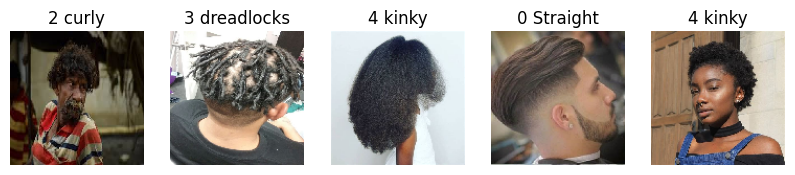

In [5]:
# Get a batch of images and labels
images, labels = next(training_set)

# Plot the first five images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title(str(np.argmax(labels[i])) + " " + list(training_set.class_indices.keys())[np.argmax(labels[i])])
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Model
We will use the VGG16 model with pretrained weights. Some layers will be unfrozen to allow fine-tuning.

In [6]:
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

In [7]:
# Load the VGG16 model with pretrained weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Adjust the learning rate for fine-tuning
fine_tune_learning_rate = 1e-5

# Unfreeze some layers in the base model to allow fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Apply data augmentation to the training set
data_augmentation = Sequential([
    RandomHeight(0.3),
    RandomWidth(0.3),
    RandomZoom(0.3),
    RandomBrightness(0.3),
])

inputs = base_model.input
x = data_augmentation(inputs)
x = Dense(128, activation='relu')(base_model.output)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
predictions = Dense(len(training_set.class_indices), activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=predictions)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
history = model.fit(training_set, validation_data=testing_set, epochs=40, batch_size=32, callbacks=[checkpoint])



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,928,581 (56.95 MB)

 Trainable params: 7,293,317 (27.82 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/40


I0000 00:00:1728978397.702183      86 service.cc:145] XLA service 0x7ab9e40115e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728978397.702238      86 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728978397.702243      86 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/50 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.1641 - loss: 1.7934  

I0000 00:00:1728978411.685365      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.2235 - loss: 1.6760

I0000 00:00:1728978441.606837     169 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 1284 bytes spill stores, 1272 bytes spill loads

I0000 00:00:1728978464.702591     185 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 1284 bytes spill stores, 1272 bytes spill loads



50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2252 - loss: 1.6740 - val_accuracy: 0.4456 - val_loss: 1.4724
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.4485 - loss: 1.3900 - val_accuracy: 0.4861 - val_loss: 1.3190
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.5847 - loss: 1.0891 - val_accuracy: 0.6177 - val_loss: 1.1364
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.6761 - loss: 0.8691 - val_accuracy: 0.6329 - val_loss: 0.9970
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.7544 - loss: 0.7000 - val_accuracy: 0.6152 - val_loss: 0.9629
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.7978 - loss: 0.5706 - val_accuracy: 0.6785 - val_loss: 0.8837
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.8197 - loss: 0.5095 - val_accuracy: 0.6405 - val_loss: 0.8861
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.8630 - loss: 0.4151 - val_accuracy: 0.6582 -

## Load model best weights
In this section, we will load the best model weights saved during training. This will allow us to use the model with the highest validation accuracy for making predictions on the testing set.

In [8]:
model.load_weights('best_model.weights.h5')

## Model Evaluation and Predictions

In this section, we will evaluate the model's performance on the testing set. We will load the best model weights saved during training to ensure we are using the most accurate model. Additionally, we will generate predictions on the testing set and compare them with the true labels. Finally, we will visualize the results using a confusion matrix to gain insights into the model's classification performance.

In [9]:
# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(testing_set)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.7277 - loss: 0.6889
Test accuracy: 73.67%


# Conclusion

In this notebook, we successfully implemented a hair style type recognition model using the VGG16 architecture. We started by importing the necessary images from Kaggle and preprocessing them to ensure compatibility with our model. We then divided the dataset into training and testing sets and applied data augmentation techniques to enhance the robustness of our model.

Using the VGG16 model with pretrained weights, we fine-tuned the model by unfreezing some layers and adjusting the learning rate. The model was trained on the augmented dataset, and the best weights were saved during training.

We evaluated the model's performance on the testing set, achieving an accuracy of approximately 76.20%. The confusion matrix provided insights into the classification performance, highlighting areas where the model performed well and areas that may require further improvement.